# Background

<img src="img/LendingClubLogo.png" width="40%" align="left">

Lending Club is a peer to peer marketplace that connects borrowers of short term unsecured fixed installment loans with investors. Lending Club screens and underwrites the loans, divides them up into $25 notes, and lists them on an online marketplace for investors to purchase.

**With so options to filter loans by, how do we select the settings that minimize loan defaults and thereby optimize our returns?**

<img src='img/filters.png' width="20%" alighn="left" style="float: left">
<img src='img/more_options.png' width="75%" alighn="left">

# Objective

With the goal of transparency, Lending Club publishes anonymized loan data for all loans issued on their platform. Using that dataset, we want to build a model to predict whether a loan will default or not.

# Hypothesis

The most important predictors in determining whether a user will default or not are:
* dti => Debt to monthly income ratio
* int_rate => Fixed interest rate on loan
* term => Number of months. Higher terms are more likely to default.
* delinq_2yrs => The Number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.
* acc_now_delinq => The Number of accounts on which the borrower is now delinquent.
* annual_inc => Annual income.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
%matplotlib inline
pd.set_option('display.max_rows', 200)

In [2]:
loans = pd.read_csv('./data/loans-kaggle.csv', low_memory=False)

In [3]:
loans.shape

(887379, 74)

In [4]:
loans.columns

Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
       u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan',
       u'url', u'desc', u'purpose', u'title', u'zip_code', u'addr_state',
       u'dti', u'delinq_2yrs', u'earliest_cr_line', u'inq_last_6mths',
       u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
       u'last_credit_pull_d', u'collections_12_mths_ex_med',
       u'mths_since_last_major_derog', u'policy_code', u'application_type',
       u'annu

### We are trying to predict whether a loan will default or not. We normalize the target variable to 0 or 1 so it becomes a binary classification.

In [5]:
loans.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [6]:
loans['defaulted'] = loans.loan_status.map({'Fully Paid': 0,
                                            'Current': 0,
                                            'Charged Off': 1,
                                            'Late (31-120 days)': 1,
                                            'Issued': 0,
                                            'In Grace Period': 0,
                                            'Late (16-30 days)': 0,
                                            'Does not meet the credit policy. Status:Fully Paid': 0,
                                            'Does not meet the credit policy. Status:Charged Off': 1,
                                            'Default': 1
                                           })
loans.drop('loan_status', axis=1, inplace=True)

## Some Exploratory Data Analysis

### What kind of interest rate are borrowers paying?

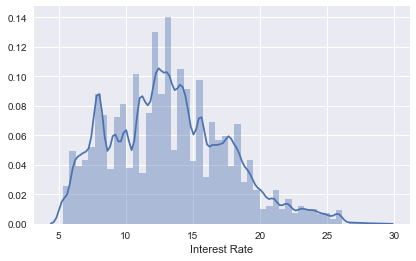

In [7]:
sns.distplot(loans.int_rate, axlabel='Interest Rate');

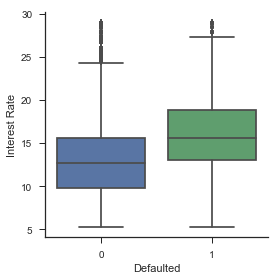

In [22]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("defaulted", "int_rate", data=loans, kind="box")
    g.set_axis_labels("Defaulted", "Interest Rate");

### How long are the loans terms?

In [9]:
loans.term.value_counts(1)

 36 months    0.699955
 60 months    0.300045
Name: term, dtype: float64

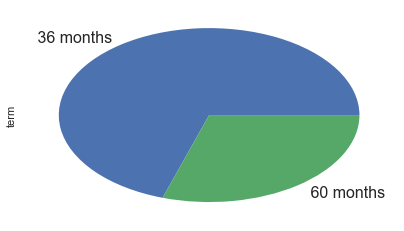

In [10]:
loans.term.value_counts().plot(kind='pie', fontsize=16);

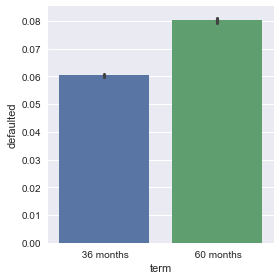

In [21]:
sns.factorplot(x='term', y='defaulted', kind='bar', data = loans);

### How much are people borrowing?

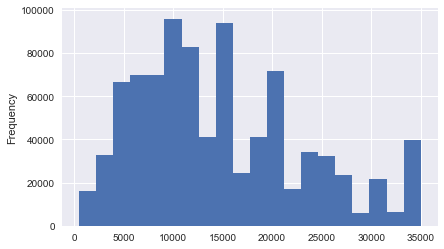

In [11]:
loans.loan_amnt.plot(kind='hist', bins=20, x='Loan Amount');

Seems like people like to round up to multiples of 5k such as 10k and 15k when applying.

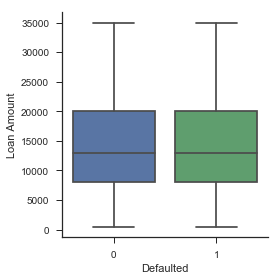

In [24]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("defaulted", "loan_amnt", data=loans, kind="box")
    g.set_axis_labels("Defaulted", "Loan Amount");

### What are people taking these loans out for?

In [25]:
purposes = loans.purpose.value_counts()
purposes

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

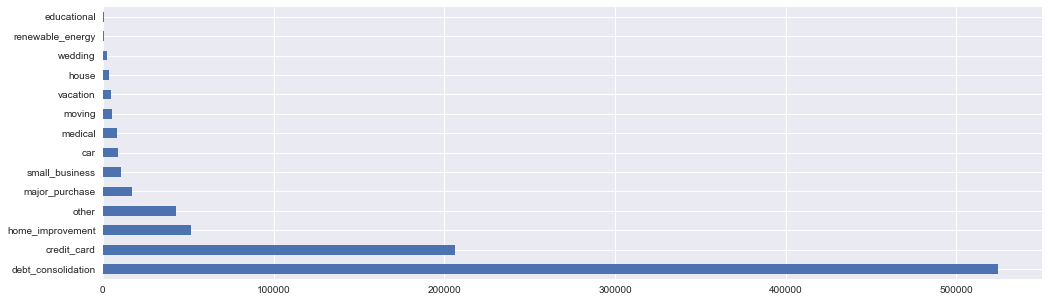

In [26]:
purposes.plot.barh(figsize=(15, 5));

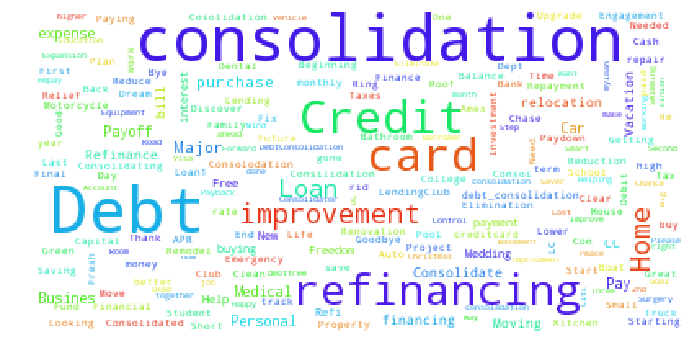

In [27]:
titles = loans.title.str.cat(sep=',')
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_font_size=40, relative_scaling=0.5)
wordcloud.generate(titles)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

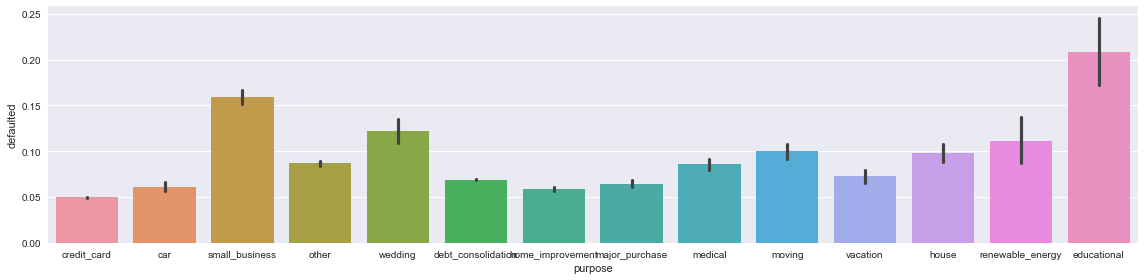

In [30]:
sns.factorplot(x='purpose', y='defaulted', kind='bar', data = loans, aspect=4);

It seems like borrowers who took out a loan for education, a small business, or wedding are more likely to default.

### How much do borrowers earn?

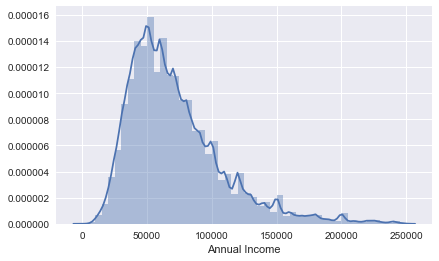

In [63]:
# Take 99th percentile to remove outliers
annual_inc_99 = loans[loans.annual_inc.notnull() & (loans.annual_inc < loans.annual_inc.quantile(0.99))]
sns.distplot(annual_inc_99.annual_inc, axlabel='Annual Income');

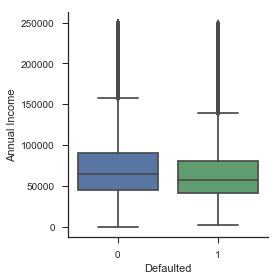

In [64]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("defaulted", "annual_inc", data=annual_inc_99, kind="box")
    g.set_axis_labels("Defaulted", "Annual Income");

### Are the borrowers renters or home owners?

In [33]:
loans.home_ownership.value_counts(1)

MORTGAGE    0.499851
RENT        0.401313
OWN         0.098571
OTHER       0.000205
NONE        0.000056
ANY         0.000003
Name: home_ownership, dtype: float64

In [34]:
loans.loc[(loans.home_ownership == 'ANY') | (loans.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'

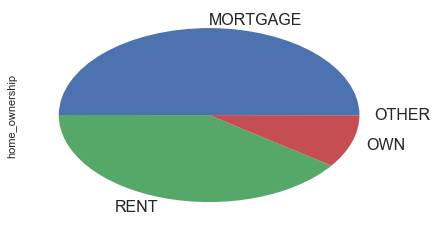

In [35]:
loans.home_ownership.value_counts().plot(kind='pie', fontsize=16);

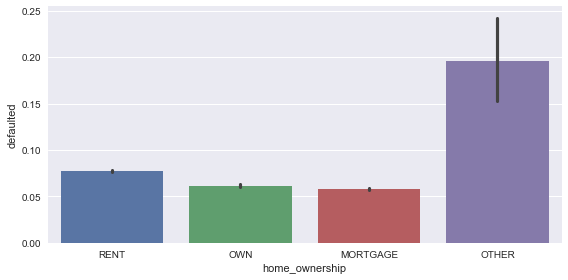

In [37]:
sns.factorplot(x='home_ownership', y='defaulted', kind='bar', data = loans, aspect=2);

### LendingClub rates their loans from A to G, with subgrades 1 to 5

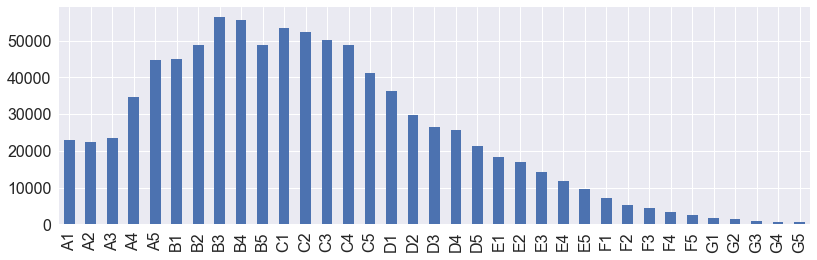

In [38]:
loans.sub_grade.value_counts().sort_index().plot(kind='bar', fontsize=16, figsize=(12, 4));

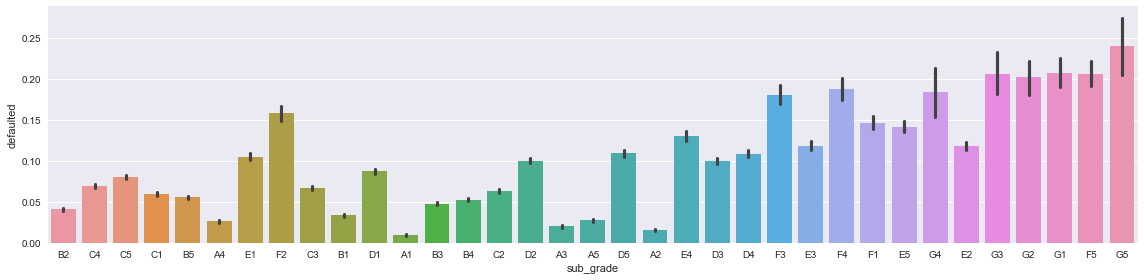

In [39]:
sns.factorplot(x='sub_grade', y='defaulted', kind='bar', data = loans, aspect=4);

### Is the number of delinquencies in the past 2 years relevant?

In [89]:
def bucketize_delinquencies(x):
    if x == 0:
        return '0'
    elif x > 0 and x <= 4:
        return '1 to 4'
    elif x > 4 and x <= 8:
        return '5 to 8'
    return '> 8'

loans['delinq_2yrs_range'] = loans.delinq_2yrs.apply(bucketize_delinquencies)

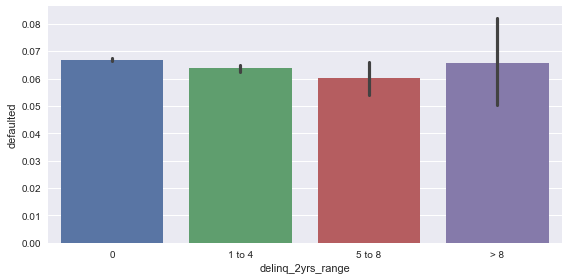

In [92]:
sns.factorplot(x='delinq_2yrs_range', y='defaulted', kind='bar', data = loans, aspect=2);

In [93]:
loans.drop('delinq_2yrs_range', axis=1, inplace=True)

### What about accounts currently delinquent?

In [95]:
loans.acc_now_delinq.value_counts()

0.0     883236
1.0       3866
2.0        208
3.0         28
4.0          7
5.0          3
6.0          1
14.0         1
Name: acc_now_delinq, dtype: int64

In [96]:
def bucketize_current_delinquent(x):
    if x == 0:
        return '0'
    elif x == 1:
        return '1'
    return '> 1'
loans['acc_now_delinq_range'] = loans.acc_now_delinq.apply(bucketize_current_delinquent)

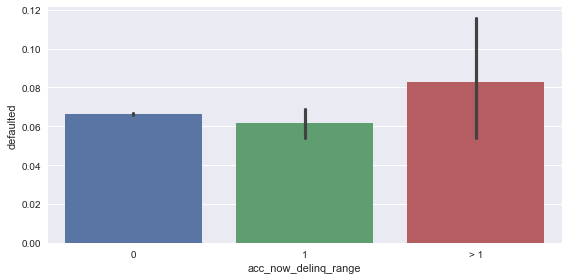

In [98]:
sns.factorplot(x='acc_now_delinq_range', y='defaulted', kind='bar', data = loans, aspect=2);

### Lots of null values. Let's clean up the data

In [ ]:
null_value_count = loans.isnull().sum().sort_values(ascending=False)
null_value_count[null_value_count != 0]

Joint applications were introduced late in 2015. For the vast majority of individual applications, set joint_dti to 0, annual_inc_joint to 0, and verification_status_joint to 'Not applicable'

In [ ]:
loans[loans.application_type == 'JOINT'].issue_d.value_counts()

In [ ]:
loans[(loans.application_type == 'JOINT') & loans.dti_joint.isnull() & loans.annual_inc_joint.isnull()
     & loans.verification_status_joint.isnull()].shape

In [ ]:
loans['dti_joint'].fillna(value=0.0, inplace=True)
loans['annual_inc_joint'].fillna(value=0.0, inplace=True)
loans['verification_status_joint'].fillna(value='Not Applicable', inplace=True)

These fields were added on December 2015 and only exist for new loans. We can just drop them.

In [ ]:
dec_2015_columns = ['il_util', 'mths_since_rcnt_il', 'open_acc_6m', 'inq_last_12m', 'open_il_6m', 'open_il_12m',
                   'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
                   'inq_fi', 'total_cu_tl', 'all_util']
loans = loans.drop(dec_2015_columns, axis=1)

Description is missing for most loans and since we are not doing any keyword or sentiment analyis, we can drop it.

In [ ]:
loans = loans.drop('desc', axis=1)

Public records are derogatory records such as bankruptcy, civil judgment, and tax liens. These values are missing because these loans have no negative public records. Let's set the value to a very high number, i.e., 1,000,000

In [ ]:
loans[loans.mths_since_last_record.isnull() & (loans.pub_rec > 0)].shape

In [ ]:
loans.mths_since_last_record.fillna(value=1000000, inplace=True)

Derogatories are public records or loans which have been delinquent for more than 90 days. mths_since_last_major_derog is the number of months since the last derogatory record. Since it's missing for most loans, we set it to the max of the column.

In [ ]:
loans['mths_since_last_major_derog'].fillna(value=loans.mths_since_last_major_derog.max(), inplace=True)

mths_since_last_delinq is the number of months since last delinquency. If they currently have a delinquent account or one in the past two years, we set it to 0. Otherwise set it to max of column.

In [ ]:
max_months = loans.mths_since_last_delinq.max()
def impute_mths_since_last_delinq(row):  
    months = max_months
    if row.acc_now_delinq > 0 or row.delinq_2yrs > 0:
        months = 0
    return months

loans.loc[loans.mths_since_last_delinq.isnull(), 'mths_since_last_delinq'] = \
    loans[loans.mths_since_last_delinq.isnull()].apply(impute_mths_since_last_delinq, axis=1)

For the following, we will impute using the median
tot_cur_bal => Total current balance of all accounts
total_rev_hi_lim => Total revolving credit limit
tot_coll_amt => Total collection amounts ever owed
revol_util => Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
collections_12_mths_ex_med => Number of collections in 12 months excluding medical collections.

In [ ]:
loans.tot_cur_bal.fillna(loans.tot_cur_bal.median(), inplace=True)
loans.total_rev_hi_lim.fillna(loans.total_rev_hi_lim.median(), inplace=True)
loans.tot_coll_amt.fillna(loans.tot_coll_amt.median(), inplace=True)
loans.revol_util.fillna(loans.revol_util.median(), inplace=True)
loans.collections_12_mths_ex_med.fillna(loans.collections_12_mths_ex_med.median(), inplace=True)

Since there are so many different employment titles, we cannot include it as a categorical feature. So we drop it.

In [ ]:
loans.emp_title.value_counts().count()

In [ ]:
loans.drop('emp_title', axis=1, inplace=True)

These 29 loans issued in the summer of 2007 when Lending Club's screening process was still being implemented. We can simply remove these loans.

In [ ]:
loans[loans.acc_now_delinq.isnull() & loans.total_acc.isnull() & loans.pub_rec.isnull() & loans.open_acc.isnull()
     & loans.inq_last_6mths.isnull() & loans.delinq_2yrs.isnull()].shape[0]

In [ ]:
loans[loans.acc_now_delinq.isnull() & loans.total_acc.isnull() & loans.pub_rec.isnull() & loans.open_acc.isnull()
     & loans.inq_last_6mths.isnull() & loans.delinq_2yrs.isnull()].issue_d.value_counts()

In [ ]:
missing_summer_2007 = ['delinq_2yrs', 'acc_now_delinq', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc']
loans.dropna(subset=missing_summer_2007, inplace=True)

Loans ID, Member ID and URL are unique to each loan, so we can drop those columns

In [ ]:
loans.drop(['id', 'member_id', 'url'], axis=1, inplace=True)

We can drop title since we already have purpose as a categorical feature.

In [ ]:
loans.drop('title', axis=1, inplace=True)

Since sub_grade encapsulates already captures grade, we can drop it.

In [ ]:
loans.drop('grade', axis=1, inplace=True)

Drop all the columns that are dates.

In [ ]:
date_columns = ['last_pymnt_d', 'earliest_cr_line', 'next_pymnt_d', 'last_credit_pull_d', 'issue_d']
loans.drop(date_columns, axis=1, inplace=True)

Employment length is ordinal. We convert it integers 0 to 10. For n/a, we assume that if the user left it blank, they are self employed or have other sources of income. So we map it 0.

In [ ]:
loans.emp_length.value_counts()

In [ ]:
def fix_employment_length(x):
    years = 0
    if x == 'n/a' or x[:1] == '<':
        years = 0
    elif x[:3] == '10+':
        years = 10
    else:
        years = int(x[:1])
    return years

loans['emp_length'] = loans.emp_length.apply(fix_employment_length)

We'll drop zip code, but keep state as a categorical feature

In [ ]:
loans.drop('zip_code', axis=1, inplace=True)

Lending Club generally sells fractional notes of whole loans. But they also sell whole loans to institutional investors who request it. initial_list_status captures that as 'w' or 'f'. Since, it's not relevant to the borrower, we drop it.

In [ ]:
loans.drop('initial_list_status', axis=1, inplace=True)

Policy code is 1 for all the loans in this dataset, so we can drop it.

In [ ]:
loans.drop('policy_code', axis=1, inplace=True)

### Create dummy variables for the categorical features

In [ ]:
loans.shape

In [ ]:
categorical_features = ['term', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose',
                       'addr_state', 'application_type', 'verification_status_joint']
loans = pd.get_dummies(loans, columns=categorical_features)

In [ ]:
loans.shape

### Let's build our classifier

In [ ]:
X = loans.drop('defaulted', axis=1)
y = loans['defaulted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#param_grid = {'n_estimators': [10,50,100,200], 'class_weight': ['balanced', None],
#              'max_depth': np.arange(1, 10)}
param_grid = {'max_depth': [4, 8]}

cv = StratifiedKFold(5, shuffle=True, random_state=42)
clf_rf = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy')
clf_rf.fit(X_train, y_train)

In [ ]:
clf_rf.best_estimator_

In [ ]:
clf_rf.best_score_

In [ ]:
feature_importances = list(zip(list(X.columns), clf_rf.best_estimator_.feature_importances_))
feature_importances.sort(lambda x, y: cmp(x[1], y[1]), reverse=True)
feature_importances[:25]

In [ ]:
y_pred_class = clf_rf.best_estimator_.predict(X_test)

In [ ]:
y_pred_prob = clf_rf.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
print metrics.accuracy_score(y_test, y_pred_class)

In [ ]:
print metrics.roc_auc_score(y_test, y_pred_prob)

In [ ]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')